In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.use('Agg')

In [2]:
import xarray as xr
import netCDF4
import glob
import numpy as np
import copy 
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
from pyproj import Proj
import datetime
import pandas as pd
import geopy.distance
import s3fs
import netCDF4 as nc
import io

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import colors
from scipy import interpolate
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
%matplotlib inline


In [3]:
def calculate_mean_bias(y_true, y_pred):
    """
    Calculate the mean bias between the true and predicted values.
    
    Parameters:
    y_true (array-like): Array of true values.
    y_pred (array-like): Array of predicted values.
    
    Returns:
    float: The mean bias value.
    """
    bias = np.nanmean(y_pred - y_true)
    return bias

def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE) between the true and predicted values.
    
    Parameters:
    y_true (array-like): Array of true values.
    y_pred (array-like): Array of predicted values.
    
    Returns:
    float: The RMSE value.
    """
    squared_errors = (y_true - y_pred) ** 2
    mean_squared_error = np.nanmean(squared_errors)
    rmse = np.sqrt(mean_squared_error)
    return rmse


def calculate_mae(y_true, y_pred):

    mae = np.nanmean(np.abs(y_pred - y_true))
    
    return mae

def input_cf_calculate_rmse_bias(Ceil_hourly_CF,cf_threshold,GOES_hourly_CF_035,GOES_hourly_CF_040,GOES_hourly_CF_045,GOES_hourly_CF_050,GOES_hourly_CF_055,GOES_hourly_CF_060):
    

    loc_all=np.where( (Ceil_hourly_CF > 0)  & \
                     ( Ceil_hourly_CF> 0  ) & (Ceil_hourly_CF<= cf_threshold ) )
    
    mean_ceil=round(np.nanmean(Ceil_hourly_CF[loc_all]),3)
    mean_035=round(np.nanmean(GOES_hourly_CF_035[loc_all]),3)
    mean_040=round(np.nanmean(GOES_hourly_CF_040[loc_all]),3)
    mean_045=round(np.nanmean(GOES_hourly_CF_045[loc_all]),3)
    mean_050=round(np.nanmean(GOES_hourly_CF_050[loc_all]),3)
    mean_055=round(np.nanmean(GOES_hourly_CF_055[loc_all]),3)
    mean_060=round(np.nanmean(GOES_hourly_CF_060[loc_all]),3)


    rmse_035=round(calculate_rmse(Ceil_hourly_CF[loc_all],GOES_hourly_CF_035[loc_all]),5)
    bias_035=round(calculate_mean_bias(Ceil_hourly_CF[loc_all],GOES_hourly_CF_035[loc_all]),3)
    mae_035=round(calculate_mae(Ceil_hourly_CF[loc_all],GOES_hourly_CF_035[loc_all]),5)
    
    
    rmse_040=round(calculate_rmse(Ceil_hourly_CF[loc_all],GOES_hourly_CF_040[loc_all]),5)
    bias_040=round(calculate_mean_bias(Ceil_hourly_CF[loc_all],GOES_hourly_CF_040[loc_all]),3)
    mae_040=round(calculate_mae(Ceil_hourly_CF[loc_all],GOES_hourly_CF_040[loc_all]),5)
    
    
    rmse_045=round(calculate_rmse(Ceil_hourly_CF[loc_all],GOES_hourly_CF_045[loc_all]),5)
    bias_045=round(calculate_mean_bias(Ceil_hourly_CF[loc_all],GOES_hourly_CF_045[loc_all]),3)
    mae_045=round(calculate_mae(Ceil_hourly_CF[loc_all],GOES_hourly_CF_045[loc_all]),5)
    
    
    rmse_050=round(calculate_rmse(Ceil_hourly_CF[loc_all],GOES_hourly_CF_050[loc_all]),5)
    bias_050=round(calculate_mean_bias(Ceil_hourly_CF[loc_all],GOES_hourly_CF_050[loc_all]),3)
    mae_050=round(calculate_mae(Ceil_hourly_CF[loc_all],GOES_hourly_CF_050[loc_all]),5)
    
    
    rmse_055=round(calculate_rmse(Ceil_hourly_CF[loc_all],GOES_hourly_CF_055[loc_all]),5)
    bias_055=round(calculate_mean_bias(Ceil_hourly_CF[loc_all],GOES_hourly_CF_055[loc_all]),3)
    mae_055=round(calculate_mae(Ceil_hourly_CF[loc_all],GOES_hourly_CF_055[loc_all]),5)
    
    
    rmse_060=round(calculate_rmse(Ceil_hourly_CF[loc_all],GOES_hourly_CF_060[loc_all]),5)
    bias_060=round(calculate_mean_bias(Ceil_hourly_CF[loc_all],GOES_hourly_CF_060[loc_all]),3)
    mae_060=round(calculate_mae(Ceil_hourly_CF[loc_all],GOES_hourly_CF_060[loc_all]),5)


    return rmse_035,rmse_040,rmse_045,rmse_050,rmse_055,rmse_060,\
           bias_035,bias_040,bias_045,bias_050,bias_055,bias_060,\
           mae_035,mae_040,mae_045,mae_050,mae_055,mae_060,\
           mean_035,mean_040,mean_045,mean_050,mean_055,mean_060,mean_ceil



In [4]:
cases=34

time_LT_5mins=np.arange( (18.-8.)*60./5.+1 )*5./60.+8. # 5 mins
half_time_bin_5mins=(time_LT_5mins[1]-time_LT_5mins[0])/2.

folder_name=np.array(['1.7_1.0','2.2_1.0','2.0_1.0']) 
correction_name=np.array(['Corrected','Corrected','Corrected'])

bias_goes_pixel=np.array([ 0.09027758,  0.01426901, -0.03432028, -0.0193933 , -0.05350255,-0.03456194, 0,0,0,0])
corrections=copy.deepcopy(bias_goes_pixel)

time_LT=np.arange( (18.-8.)*60./60.+1 )*60./60.+8. # 60 mins
half_time_bin=(time_LT[1]-time_LT[0])/2.

# with bin
CF_bin=np.arange(10)*0.1+0.05
CF_bin_width=CF_bin[1]-CF_bin[0]
CF_bin.shape,CF_bin_width,CF_bin

((10,),
 0.10000000000000002,
 array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]))

In [5]:
sample_045=np.empty((len(folder_name),len(CF_bin)))
sample_050=np.empty((len(folder_name),len(CF_bin)))
sample_055=np.empty((len(folder_name),len(CF_bin)))
sample_040=np.empty((len(folder_name),len(CF_bin)))

bias_1km_045=np.empty((len(folder_name),len(CF_bin)))
bias_1km_050=np.empty((len(folder_name),len(CF_bin)))
bias_1km_055=np.empty((len(folder_name),len(CF_bin)))
bias_1km_040=np.empty((len(folder_name),len(CF_bin)))

bias_std_error_1km_045=np.empty((len(folder_name),len(CF_bin)))
bias_std_error_1km_050=np.empty((len(folder_name),len(CF_bin)))
bias_std_error_1km_055=np.empty((len(folder_name),len(CF_bin)))
bias_std_error_1km_040=np.empty((len(folder_name),len(CF_bin)))

rmse_06=np.empty(( (len(folder_name)), (6) )) # 6 thresholds
mae_06=np.empty(( (len(folder_name)), (6) )) # 6 thresholds
bias_06=np.empty(( (len(folder_name)), (6) )) # 6 thresholds
mean_06=np.empty(( (len(folder_name)), (7) )) # 6 thresholds+ceil


In [7]:
for mmm in np.arange(len(folder_name)):

    
    GOES_dir=f'./Data/'
    
    
    GOES_filein=f'{GOES_dir}*{folder_name[mmm]}*.nc'
    GOES_output_list=glob.glob(GOES_filein)
    GOES_data = xr.open_dataset(GOES_output_list[0])
    
    time_5mins=GOES_data.time_5mins.values

    
    GOES_CF_035_5mins=GOES_data.GOES_CF_035_5mins.values
    GOES_CF_040_5mins=GOES_data.GOES_CF_040_5mins.values 
    GOES_CF_045_5mins=GOES_data.GOES_CF_045_5mins.values 
    GOES_CF_050_5mins=GOES_data.GOES_CF_050_5mins.values
    GOES_CF_055_5mins=GOES_data.GOES_CF_055_5mins.values
    GOES_CF_060_5mins=GOES_data.GOES_CF_060_5mins.values

    Ceil_CF_5mins=GOES_data.Ceil_CF_5mins.values
    
    ###Correction###
    
    GOES_CF_035_5mins_correct=np.empty_like(GOES_CF_035_5mins)*np.nan
    GOES_CF_040_5mins_correct=np.empty_like(GOES_CF_040_5mins)*np.nan
    GOES_CF_045_5mins_correct=np.empty_like(GOES_CF_045_5mins)*np.nan
    GOES_CF_050_5mins_correct=np.empty_like(GOES_CF_050_5mins)*np.nan
    GOES_CF_055_5mins_correct=np.empty_like(GOES_CF_055_5mins)*np.nan
    GOES_CF_060_5mins_correct=np.empty_like(GOES_CF_060_5mins)*np.nan

    #####
    for i in np.arange(len(CF_bin)):

        loc_bins=np.where( (Ceil_CF_5mins>(CF_bin[i]-CF_bin_width/2.) ) & (Ceil_CF_5mins<=(CF_bin[i]+CF_bin_width/2.) )  )   
        
        if loc_bins[0].shape[0]>0:

            GOES_CF_035_5mins_correct[loc_bins]=GOES_CF_035_5mins[loc_bins]-corrections[i]
            GOES_CF_040_5mins_correct[loc_bins]=GOES_CF_040_5mins[loc_bins]-corrections[i]        
            GOES_CF_045_5mins_correct[loc_bins]=GOES_CF_045_5mins[loc_bins]-corrections[i]    
            GOES_CF_050_5mins_correct[loc_bins]=GOES_CF_050_5mins[loc_bins]-corrections[i]
            GOES_CF_055_5mins_correct[loc_bins]=GOES_CF_055_5mins[loc_bins]-corrections[i]    
            GOES_CF_060_5mins_correct[loc_bins]=GOES_CF_060_5mins[loc_bins]-corrections[i]
            
            
    GOES_CF_035_5mins_correct[GOES_CF_035_5mins_correct<0]=0         
    GOES_CF_040_5mins_correct[GOES_CF_040_5mins_correct<0]=0    
    GOES_CF_045_5mins_correct[GOES_CF_045_5mins_correct<0]=0    
    GOES_CF_050_5mins_correct[GOES_CF_050_5mins_correct<0]=0    
    GOES_CF_055_5mins_correct[GOES_CF_055_5mins_correct<0]=0    
    GOES_CF_060_5mins_correct[GOES_CF_060_5mins_correct<0]=0    
    
    
    GOES_CF_035_5mins_correct[GOES_CF_035_5mins_correct>1]=1         
    GOES_CF_040_5mins_correct[GOES_CF_040_5mins_correct>1]=1    
    GOES_CF_045_5mins_correct[GOES_CF_045_5mins_correct>1]=1    
    GOES_CF_050_5mins_correct[GOES_CF_050_5mins_correct>1]=1    
    GOES_CF_055_5mins_correct[GOES_CF_055_5mins_correct>1]=1    
    GOES_CF_060_5mins_correct[GOES_CF_060_5mins_correct>1]=1             
            
    ####Do the average###
    
    GOES_hourly_CF_035=np.zeros( (cases,len(time_LT)) )*np.nan
    GOES_hourly_CF_040=np.zeros( (cases,len(time_LT)) )*np.nan
    GOES_hourly_CF_045=np.zeros( (cases,len(time_LT)) )*np.nan
    GOES_hourly_CF_050=np.zeros( (cases,len(time_LT)) )*np.nan
    GOES_hourly_CF_055=np.zeros( (cases,len(time_LT)) )*np.nan
    GOES_hourly_CF_060=np.zeros( (cases,len(time_LT)) )*np.nan
    Ceil_hourly_CF=np.zeros( (cases,len(time_LT)) )*np.nan    

    
    for j in np.arange(cases):

        for i in np.arange(len(time_LT)):

            loc=np.where(  (time_5mins>= (time_LT[i]-half_time_bin) ) & (time_5mins< (time_LT[i]+half_time_bin)  ) )

            if loc[0].shape[0]>0:

                GOES_hourly_CF_035[j,i]=np.nanmean(GOES_CF_035_5mins_correct[j,loc])
                GOES_hourly_CF_040[j,i]=np.nanmean(GOES_CF_040_5mins_correct[j,loc])
                GOES_hourly_CF_045[j,i]=np.nanmean(GOES_CF_045_5mins_correct[j,loc])            
                GOES_hourly_CF_050[j,i]=np.nanmean(GOES_CF_050_5mins_correct[j,loc])
                GOES_hourly_CF_055[j,i]=np.nanmean(GOES_CF_055_5mins_correct[j,loc])
                GOES_hourly_CF_060[j,i]=np.nanmean(GOES_CF_060_5mins_correct[j,loc])            

                Ceil_hourly_CF[j,i]=np.nanmean(Ceil_CF_5mins[j,loc])                


                
    ###Read in Cloud Base###
    CB_mean_1hour=GOES_data.CB_mean_1hour.values


    
    ####Calculate the Bias###For Plot###
    for i in np.arange(len(CF_bin)):


        loc_bin_045=np.where( (GOES_hourly_CF_045>0) & (Ceil_hourly_CF > 0)  & (CB_mean_1hour>0) & (CB_mean_1hour<3) & \
                     ( Ceil_hourly_CF> (CF_bin[i]-CF_bin_width/2.)  ) & (Ceil_hourly_CF<= (CF_bin[i]+CF_bin_width/2.) ) )

        loc_bin_050=np.where( (GOES_hourly_CF_050>0) & (Ceil_hourly_CF > 0)  & (CB_mean_1hour>0) & (CB_mean_1hour<3) & \
                     ( Ceil_hourly_CF> (CF_bin[i]-CF_bin_width/2.)  ) & (Ceil_hourly_CF<= (CF_bin[i]+CF_bin_width/2.) ) )

        loc_bin_055=np.where( (GOES_hourly_CF_055>0) & (Ceil_hourly_CF > 0)  & (CB_mean_1hour>0) & (CB_mean_1hour<3) & \
                     ( Ceil_hourly_CF> (CF_bin[i]-CF_bin_width/2.)  ) & (Ceil_hourly_CF<= (CF_bin[i]+CF_bin_width/2.) ) )

        loc_bin_040=np.where( (GOES_hourly_CF_040>0) & (Ceil_hourly_CF > 0)  & (CB_mean_1hour>0) & (CB_mean_1hour<3) & \
                     ( Ceil_hourly_CF> (CF_bin[i]-CF_bin_width/2.)  ) & (Ceil_hourly_CF<= (CF_bin[i]+CF_bin_width/2.) ) )

        
        ###Sample Number###
        sample_045[mmm,i]=loc_bin_045[0].shape[0]
        sample_050[mmm,i]=loc_bin_050[0].shape[0]
        sample_055[mmm,i]=loc_bin_055[0].shape[0]
        sample_040[mmm,i]=loc_bin_040[0].shape[0]

        
        #np.nanmean(b)-np.nanmean(a)
        bias_1km_045[mmm,i]=np.nanmean( GOES_hourly_CF_045[loc_bin_045])-np.nanmean(Ceil_hourly_CF[loc_bin_045] )
        bias_1km_050[mmm,i]=np.nanmean( GOES_hourly_CF_050[loc_bin_050])-np.nanmean(Ceil_hourly_CF[loc_bin_050] )
        bias_1km_055[mmm,i]=np.nanmean( GOES_hourly_CF_055[loc_bin_055])-np.nanmean(Ceil_hourly_CF[loc_bin_055] )
        bias_1km_040[mmm,i]=np.nanmean( GOES_hourly_CF_040[loc_bin_040])-np.nanmean(Ceil_hourly_CF[loc_bin_040] )

        b=GOES_hourly_CF_045[loc_bin_045]-Ceil_hourly_CF[loc_bin_045]
        bias_std_error_1km_045[mmm,i]=np.nanstd(b)/np.sqrt(len(b))

        d=GOES_hourly_CF_050[loc_bin_050]-Ceil_hourly_CF[loc_bin_050]
        bias_std_error_1km_050[mmm,i]=np.nanstd(d)/np.sqrt(len(d))

        c=GOES_hourly_CF_055[loc_bin_055]-Ceil_hourly_CF[loc_bin_055]
        bias_std_error_1km_055[mmm,i]=np.nanstd(c)/np.sqrt(len(c))

        a=GOES_hourly_CF_040[loc_bin_040]-Ceil_hourly_CF[loc_bin_040]
        bias_std_error_1km_040[mmm,i]=np.nanstd(a)/np.sqrt(len(a))
        

        #####
        
    rmse_06[mmm,0],rmse_06[mmm,1],rmse_06[mmm,2],rmse_06[mmm,3],rmse_06[mmm,4],rmse_06[mmm,5],\
    bias_06[mmm,0],bias_06[mmm,1],bias_06[mmm,2],bias_06[mmm,3],bias_06[mmm,4],bias_06[mmm,5],\
    mae_06[mmm,0],mae_06[mmm,1],mae_06[mmm,2],mae_06[mmm,3],mae_06[mmm,4],mae_06[mmm,5],\
    mean_06[mmm,0],mean_06[mmm,1],mean_06[mmm,2],mean_06[mmm,3],mean_06[mmm,4],mean_06[mmm,5],mean_06[mmm,6]\
    =input_cf_calculate_rmse_bias(Ceil_hourly_CF,0.6,GOES_hourly_CF_035,GOES_hourly_CF_040,GOES_hourly_CF_045,GOES_hourly_CF_050,GOES_hourly_CF_055,GOES_hourly_CF_060)

    


# Merging into 1 figure

In [8]:
mmm=2

In [9]:
delta_R=np.array([0.035,0.040,0.045,0.05,0.055,0.06])

142


Text(0.0, 1.0, '(c)')

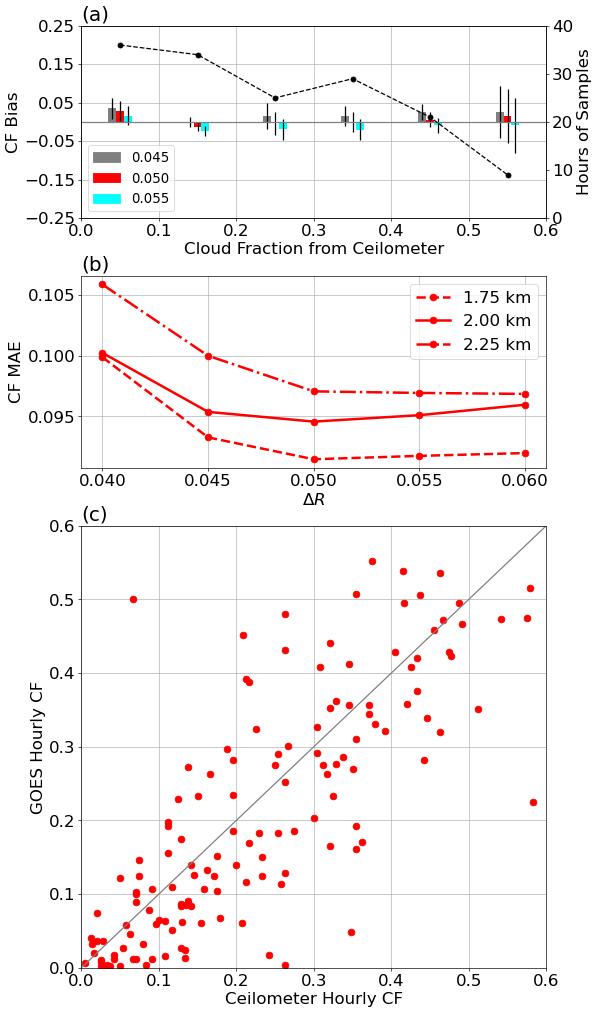

In [10]:
mpl.rcParams['font.size'] = 20
mpl.rcParams['font.weight'] = 'regular'
mpl.rcParams['font.family'] = 'DejaVu Sans'
fig = plt.figure(figsize=[10,20], dpi=60)

gs = gridspec.GridSpec(4, 20)
gs.update(wspace=0.5, hspace=0.3, top=0.91)

ax6 = plt.subplot(gs[0,0:20])
ax61 = plt.subplot(gs[1,0:20])
ax4 = plt.subplot(gs[2:4,0:20])


#####


ax6.bar(CF_bin-0.01,bias_1km_045[mmm,:],yerr=bias_std_error_1km_045[mmm,:],color='grey',width=0.01, align='center')
ax6.bar(CF_bin,bias_1km_050[mmm,:],yerr=bias_std_error_1km_050[mmm,:],color='red',width=0.01, align='center')
ax6.bar(CF_bin+0.01,bias_1km_055[mmm,:],yerr=bias_std_error_1km_055[mmm,:],color='cyan',width=0.01, align='center')

colors = {f'0.045':'grey', f'0.050':'red', f'0.055':'cyan'}   
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

ax6.set_xlabel('Cloud Fraction from Ceilometer')
ax6.set_ylabel('CF Bias')

ax6.grid()
ax6.axhline(y=0, color='grey', linestyle='-')

ax6.legend(handles, labels,fontsize=16,loc='lower left')
ax6.set_ylim(-0.25,0.25)
ax6.set_yticks(np.arange(-0.25,0.35, 0.1))
ax6.set_xlim(0.,0.6)
ax6.set_title(f'(a)', loc='left')


# Create a secondary y-axis for sample numbers
ax6_right = ax6.twinx()
ax6_right.plot(CF_bin[:6], sample_050[mmm, :6], '--',marker='o', color='black')
ax6_right.set_ylim(0, 40)
ax6_right.set_ylabel('Hours of Samples')
ax6_right.grid(False) 

#####MAE####

ax61.plot(delta_R[1:],mae_06[0,1:],'--',marker='o',color='red',label='1.75 km',linewidth=3,markersize=8)
ax61.plot(delta_R[1:],mae_06[2,1:],'-o',color='red',label='2.00 km',linewidth=3,markersize=8)
ax61.plot(delta_R[1:],mae_06[1,1:],'-.',marker='o',color='red',label='2.25 km',linewidth=3,markersize=8)
ax61.set_xlabel(r'$\Delta R$')
ax61.set_ylabel('CF MAE')
ax61.grid()
ax61.legend(fontsize=20)
ax61.set_title(f'(b)', loc='left')
ax61.set_xticks(delta_R[1:])

#####
loc=np.where((CB_mean_1hour>0) & (CB_mean_1hour<3) & (Ceil_hourly_CF>0) & (GOES_hourly_CF_050>0) & (Ceil_hourly_CF<=0.6) & (GOES_hourly_CF_050<=0.6) )
print(loc[0].shape[0])
ax4.plot(Ceil_hourly_CF[loc],GOES_hourly_CF_050[loc],'o',color='red',markersize=8)
ax4.plot([0, 1.0], [0, 1.0], color='grey')
ax4.grid()
ax4.set_xlim(0, 0.6)
ax4.set_ylim(0, 0.6)
ax4.set_xlabel('Ceilometer Hourly CF')
ax4.set_ylabel('GOES Hourly CF')
ax4.set_title(f'(c)', loc='left')
#####

#fig.savefig(f'./Figure_deltaR_bias_MAE_scatter.png', dpi=300, bbox_inches='tight') 

